In [1]:
import numpy as np
import time
from collections import namedtuple
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import qiskit as q
import qiskit.tools.jupyter
from qiskit.pulse import pulse_lib as _  # only want to call pulse_lib as q.pulse.pulse_lib

In [3]:
q.IBMQ.load_account() # Load account from disk
q.IBMQ.providers()    # List all available providers

[<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>,
 <AccountProvider for IBMQ(hub='ibm-q-ornl', group='bes-qis', project='argonne')>]

In [4]:
provider = q.IBMQ.get_provider(group='bes-qis')
backend = provider.get_backend('ibmq_boeblingen')
system = q.pulse.PulseChannelSpec.from_backend(backend)
config = backend.configuration()
defaults = backend.defaults()
cmd_def = q.pulse.CmdDef.from_defaults(backend.defaults().cmd_def, backend.defaults().pulse_library)
measure = cmd_def.get('measure', qubits=config.meas_map[0])

In [5]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='610px', min_width='610px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [10]:
def get_schedule_from_circuit(circuit):
    """
    Ignores measurements and barriers. No intelligent parallelization of schedule.
    """
    schedule = q.pulse.Schedule()

    for inst, qubits, _ in circuit.data:
        if isinstance(inst, q.extensions.Barrier) or isinstance(inst, q.circuit.Measure):
            continue

        inst_qubits = [qubit.index for qubit in qubits]
        schedule += cmd_def.get(inst.name, inst_qubits, *inst.params)

    return schedule

In [34]:
def get_qpt_schedules_and_circs(base_schedule):
    qreg = q.QuantumRegister(20)
    circ = q.QuantumCircuit(qreg)
    
    qpt_circs = q.ignis.verification.tomography.process_tomography_circuits(
        circ, prepared_qubits=[qreg[0]], measured_qubits=[qreg[0]])
    
    qpt_schedules = []
    
    for qpt_circ in qpt_circs:
        done_with_prep = False
        prep_circuit, meas_circuit = q.QuantumCircuit(), q.QuantumCircuit()

        layers = q.converters.circuit_to_dag(qpt_circ).layers()
        layer_circuits = list(map(lambda layer: qiskit.converters.dag_to_circuit(layer['graph']), layers))
        next_layer_circuit = layer_circuits.pop(0)

        while not done_with_prep:
            if next_layer_circuit.data[0][0].name == 'barrier':
                done_with_prep = True
            else:
                prep_circuit.extend(next_layer_circuit)
            next_layer_circuit = layer_circuits.pop(0)
        prep_schedule = get_schedule_from_circuit(prep_circuit.decompose())

        while True:
            if next_layer_circuit.data[0][0].name == 'barrier':
                break
            next_layer_circuit = layer_circuits.pop(0)

        for layer_circuit in layer_circuits:
            meas_circuit.extend(layer_circuit)
        meas_schedule = get_schedule_from_circuit(meas_circuit.decompose())
        meas_schedule += cmd_def.get('measure', qubits=config.meas_map[0])
        
        schedule = q.pulse.Schedule(name=qpt_circ.name) + prep_schedule + base_schedule + meas_schedule
        qpt_schedules.append(schedule)
    
    return qpt_schedules, qpt_circs

In [35]:
qpt_schedules, qpt_circs = get_qpt_schedules_and_circs(cmd_def.get('x', qubits=[0]))

In [36]:
job = qiskit.execute(qpt_schedules, backend=backend, shots=1000)
print(job.job_id())

5d97b279d4308b0011992c51


In [37]:
job_id = '5d97b279d4308b0011992c51'
job = backend.retrieve_job(job_id)

In [38]:
qpt_tomo = q.ignis.verification.tomography.ProcessTomographyFitter(job.result(), qpt_circs)

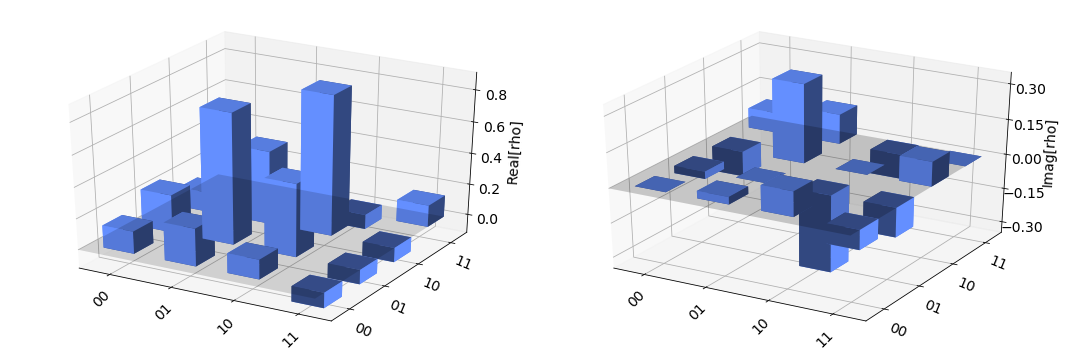

In [53]:
choi_lstsq = qpt_tomo.fit(method='lstsq')
q.tools.visualization.plot_state_city(choi_lstsq.data)

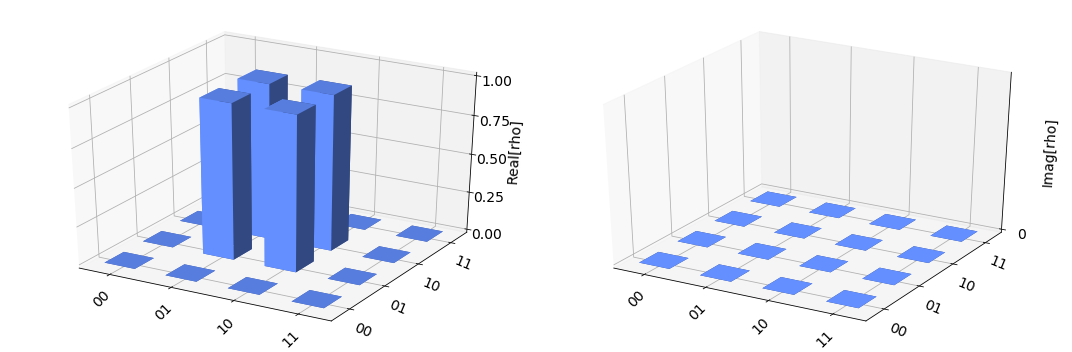

In [54]:
qreg = q.QuantumRegister(1)
circ = q.QuantumCircuit(qreg)
circ.x(0)

job = qiskit.execute(circ, q.Aer.get_backend('unitary_simulator'))
ideal_unitary = job.result().get_unitary(circ)
choi_ideal = q.tools.qi.qi.outer(ideal_unitary.ravel(order='F'))

q.tools.visualization.plot_state_city(choi_ideal)

In [55]:
print('fit fidelity (process):',
      np.real(q.quantum_info.process_fidelity(choi_ideal, choi_lstsq.data, require_cptp=False)))

fit fidelity (process): 0.4386691347936683
